In [221]:
%matplotlib ipympl
import time
import pandas
import json
import traceback
from onix.data_tools import get_experiment_data, open_analysis_folder, get_analysis_file_path
from functools import partial
from onix.analysis.fitter import Fitter
from onix.analysis.helper import group_and_average_data
from onix.units import ureg
from onix.helpers import present_float
import numpy as np
from matplotlib import colormaps
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.special import voigt_profile
import allantools
from tqdm import tqdm
from uncertainties import ufloat, unumpy
from scipy.stats import pearsonr
from allantools import adev
from datetime import datetime

In [222]:
def data_identification_to_list(data_identification):
    if isinstance(data_identification, tuple):
        return range(data_identification[0], data_identification[1] + 1)
    elif isinstance(data_identification, int):
        return [data_identification]
    else:
        # it should be a list
        return data_identification

In [223]:
def get_average_heights(data_number):
    data, headers = get_experiment_data(data_number)

    detunings_MHz = headers["detunings"].to("MHz").magnitude
    transmissions_avg = group_and_average_data(data["transmissions_avg"], headers["params"]["detect"]["cycles"])
    monitors_avg = group_and_average_data(data["monitors_avg"], headers["params"]["detect"]["cycles"])
    
    plt_monitor = True
    use_positive = None
    
    antihole_avg = transmissions_avg["antihole"]
    rf_avg = transmissions_avg["rf"]
    if "chasm" in transmissions_avg:
        chasm_avg = transmissions_avg["chasm"]
        antihole_normalized = antihole_avg / chasm_avg
        rf_normalized = rf_avg / chasm_avg
    else:
        chasm_avg = None
        antihole_normalized = antihole_avg / monitors_avg["antihole"]
        rf_normalized = rf_avg / monitors_avg["rf"]
    if "lf" in transmissions_avg:
        lf_normalized = transmissions_avg["lf"] / monitors_avg["lf"]
    
    if headers["params"]["field_plate"]["use"]:
        if "use_opposite_field" not in headers["params"]["field_plate"]:
            hat_E = (headers["params"]["field_plate"]["amplitude"] > 0)
        else:
            hat_E = (headers["params"]["field_plate"]["amplitude"] > 0) == (not headers["params"]["field_plate"]["use_opposite_field"])
        hat_probe = headers["params"]["field_plate"]["stark_shift"] > 0
        mask = detunings_MHz > 0
        mask1 = detunings_MHz < 0
        if "lf" in transmissions_avg:
            return (np.array([np.average(antihole_normalized[mask]), np.average(antihole_normalized[mask1])]), 
            np.array([np.average(rf_normalized[mask]), np.average(rf_normalized[mask1])]), 
            np.array([np.average(lf_normalized[mask]), np.average(lf_normalized[mask1])]), headers, (hat_E, hat_probe))
        else:
            return (
                np.array([
                    np.average(antihole_normalized[mask]), np.average(antihole_normalized[mask1])
                ]),
                np.array([
                    np.average(rf_normalized[mask]), np.average(rf_normalized[mask1])
                ]),
                np.array([
                    np.std(antihole_normalized[mask]) / np.sqrt(len(antihole_normalized[mask])), np.std(antihole_normalized[mask1]) / np.sqrt(len(antihole_normalized[mask1]))
                ]),
                np.array([
                    np.std(rf_normalized[mask]) / np.sqrt(len(antihole_normalized[mask])), np.std(rf_normalized[mask1]) / np.sqrt(len(antihole_normalized[mask1]))
                ]),
                headers,
                (hat_E, hat_probe),
            )
            
    else:
        return np.average(antihole_normalized), np.average(rf_normalized), headers, None

def get_voltage_ratios(data_list):
    ratios = []
    ratios_err = []
    ratios2 = []
    headers = []
    E_fields = []
    # for kk in data_list:
    #     h1, h2, h3, header, E_field = get_average_heights(kk)
    #     ratios.append(h2 / h1)
    #     ratios2.append((h3-h2)/(h2-h1))
    #     headers.append(header)
    #     E_fields.append(E_field)
    # return np.array(ratios), np.array(ratios2), headers, E_fields
    for kk in data_list:
        h1, h2, h1_err, h2_err, header, E_field = get_average_heights(kk)
        ratios.append(h2 / h1)
        ratios_err.append(np.sqrt((h2_err / h1) ** 2 + (h1_err * h2 / h1**2) ** 2))
        headers.append(header)
        E_fields.append(E_field)
    return np.ones(len(ratios)), np.array(ratios), np.array(ratios_err), headers, E_fields

In [224]:
def uniform_averaging(average_time, *args):
    """Averages times and frequencies data, and samples them at the same times.
    
    Args can be any number of pairs of times and freqs.
    """
    all_data = {}
    for kk in range(len(args) // 2):
        all_data[f"d{kk}"] = np.array([args[kk * 2], args[kk * 2 + 1]])
    min_time = 0
    max_time = np.inf
    for kk in all_data:
        dataset_min_time = np.min(all_data[kk][0])
        dataset_max_time = np.max(all_data[kk][0])
        if dataset_max_time < max_time:
            max_time = dataset_max_time
        if dataset_min_time > min_time:
            min_time = dataset_min_time
    sample_times = np.arange(min_time + average_time / 2, max_time - average_time / 2, average_time)
    frequencies_sampled = {}
    for kk in all_data:
        frequencies = []
        for sample_time in sample_times:
            mask = (all_data[kk][0] >= sample_time - average_time / 2) & (all_data[kk][0] < sample_time + average_time / 2)
            frequencies.append(np.average(all_data[kk][1][mask]))
        frequencies_sampled[kk] = np.array(frequencies)
    return tuple([sample_times] + list(frequencies_sampled.values()))

def moving_average(a, n=3):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

average_time = 100

In [369]:
# if input(f"Create new analysis folder? (y/n) ") == "y":
#     analysis_folder_index = open_analysis_folder("lf_spectroscopy")
# else:
#     analysis_folder_index = int(input("Enter analysis number: "))
# print("Current analysis number: ", analysis_folder_index)

In [370]:
# if input(f"Save in analysis #{analysis_folder_index}? (y/n) ") == "y":
#     with open(get_analysis_file_path(analysis_folder_index, "all_data.json"), "w") as f:
#         json.dump(all_results, f)

## Ramsey time series

In [271]:
data_range = (823621, 823624)
max = 825620 # 841716
first = data_range[0]
last = max

all_results = {
    "freq_center": [],
    "state": [],
    "E": [],
    "D": [],
    "detect_red_first": [],
    "data_indices": [],
    "start_time": [],
    "end_time": [],
    "center_freq_kHz": [],
    "field_plate_amplitude": [],
    "stark_shift_MHz": [],
}

current = data_range[-1]
offset = 0
while current + offset <= max:
    data_range_now = (data_range[0] + offset, data_range[1] + offset)
    data_list = data_identification_to_list(data_range_now)
    ratios_bg, ratios, ratios_err, headers, E_field = get_voltage_ratios(data_list)
    if E_field.count(E_field[0]) != len(E_field):
        raise Exception("Data with different E or detect order")
    detunings = [header["params"]["lf"]["detuning"].to("Hz").magnitude for header in headers]
    phases = [header["params"]["lf"]["phase_diff"] for header in headers]
    center_freqs = [header["params"]["lf"]["center_frequency"] for header in headers]
    fp_amplitudes = [header["params"]["field_plate"]["amplitude"] for header in headers]
    stark_shifts = [header["params"]["field_plate"]["stark_shift"] for header in headers]
    ys = (1-ratios)
    ys_err = ratios_err

    if center_freqs.count(center_freqs[0]) != len(center_freqs):
        raise Exception("Different center frequencies used.")
    center_freq = center_freqs[0]
    if fp_amplitudes.count(fp_amplitudes[0]) != len(fp_amplitudes):
        raise Exception("Different field plate amplitudes used.")
    fp_amplitude = fp_amplitudes[0]
    if stark_shifts.count(stark_shifts[0]) != len(stark_shifts):
        raise Exception("Different stark shifts used.")
    stark_shift = stark_shifts[0]
    detunings = np.array(detunings) + center_freq.to("Hz").magnitude
    detuning_diff = np.max(detunings) - np.min(detunings)
    negative_detuning_mask = detunings == np.min(detunings)
    positive_detuning_mask = detunings == np.max(detunings)
    if np.min(detunings) == np.max(detunings):
        raise Exception("Data only has one detuning")
    negative_phase_mask = phases == np.min(phases)
    positive_phase_mask = phases == np.max(phases)
    if np.min(phases) == np.max(phases):
        raise Exception("Data only has one phase")
    for kk in range(2):  # positive and negative Stark components.
        ys_red_diff = ys[negative_detuning_mask & positive_phase_mask][0][kk] - ys[negative_detuning_mask & negative_phase_mask][0][kk]
        ys_red_diff_err = np.sqrt(ys_err[negative_detuning_mask & positive_phase_mask][0][kk]**2 + ys_err[negative_detuning_mask & negative_phase_mask][0][kk]**2)
        ys_red_diff = ufloat(ys_red_diff, ys_red_diff_err)
        ys_blue_diff = ys[positive_detuning_mask & negative_phase_mask][0][kk] - ys[positive_detuning_mask & positive_phase_mask][0][kk]
        ys_blue_diff_err = np.sqrt(ys_err[positive_detuning_mask & negative_phase_mask][0][kk]**2 + ys_err[positive_detuning_mask & positive_phase_mask][0][kk]**2)
        ys_blue_diff = ufloat(ys_blue_diff, ys_blue_diff_err)
        freq_center = detuning_diff * ys_red_diff / (ys_red_diff + ys_blue_diff) + detunings[0]
        neg_DdotE = kk == 0
        E = E_field[0][0]
        D = (not neg_DdotE) == E
        detect_order = E_field[0][1]
        epoch_times = (
            headers[0]["start_time"],
            headers[-1]["data_info"]["save_epoch_time"],
        )
        if center_freq.to("kHz").magnitude > 200:
            state = "a"
        else:
            state = "b"
        all_results["freq_center"].append(freq_center)
        all_results["state"].append(state)
        all_results["E"].append(E)
        all_results["D"].append(D)
        all_results["detect_red_first"].append(detect_order)
        all_results["data_indices"].append(list(data_list))
        all_results["start_time"].append(epoch_times[0])
        all_results["end_time"].append(epoch_times[1])
        all_results["center_freq_kHz"].append(center_freq.to("kHz").magnitude)
        all_results["field_plate_amplitude"].append(fp_amplitude)
        all_results["stark_shift_MHz"].append(stark_shift.to("MHz").magnitude)
    offset += len(list(data_list))
    
for kk in all_results:
    if kk == "data_indices":
        continue
    all_results[kk] = np.array(all_results[kk])

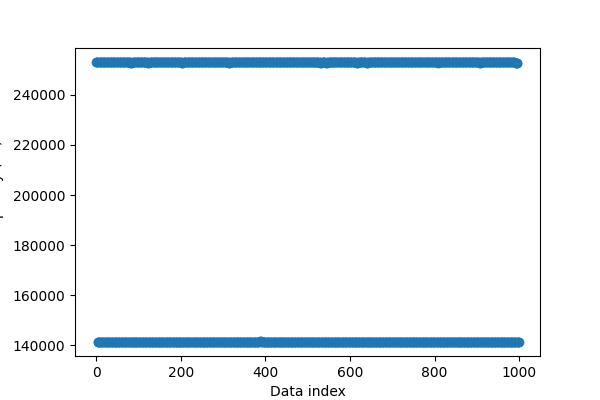

In [272]:
fs = unumpy.nominal_values(all_results["freq_center"])
fs_err = unumpy.std_devs(all_results["freq_center"])

fig, ax = plt.subplots(figsize=(6, 4))
ax.errorbar(np.arange(len(fs)), fs, fs_err, fmt="o", ls="none")

ax.set_xlabel("Data index")
ax.set_ylabel("$b\\bar{b}$ frequency (Hz)")
plt.show()

In [291]:
import onix.models.hyperfine as hyperfine
magnetic_field = 223e-4
ground = hyperfine.states["7F0"]
ground._Hamiltonian = ground.H_total(magnetic_field)
e_g, s_g = ground.energies_and_eigenstates()

a_I_dot_n = (s_g[0].dag() * ground._I_x * s_g[0]).tr()
abar_I_dot_n = (s_g[1].dag() * ground._I_x * s_g[1]).tr()
b_I_dot_n = (s_g[2].dag() * ground._I_x * s_g[2]).tr()
bbar_I_dot_n = (s_g[3].dag() * ground._I_x * s_g[3]).tr()
I_a = (abar_I_dot_n - a_I_dot_n) / 2
I_b = (bbar_I_dot_n - b_I_dot_n) / 2

def combine_polarization_data(results):
    def check_equal_and_append(check_from, check_name, append_to):
        check_col = check_from[:, col_indices[check_name]]
        count = np.unique(check_col)
        if len(count) > 1:
            raise Exception(f"{check_name} is not the same.")
        append_to.append(check_col[0])

    results_array = pandas.DataFrame.from_dict(results).to_numpy()
    keys = list(results.keys())
    indices = list(range(len(keys)))
    col_indices = dict(zip(keys, indices))
    data = {
        "f+": [], "f-": [], "E": [], "detect_red_first": [], "start_time": [], "end_time": [], "state": [], "data_indices": [],
        "field_plate_amplitude": [], "electric_field_shift_MHz": [], "center_freq_kHz": [],
        "Z": [], "W_T": [],
    }
    for kk in range(len(results_array) // 2):
        sub_data = results_array[kk * 2: kk * 2 + 2]
        data_indices = []
        check_equal_and_append(sub_data, "E", data["E"])
        check_equal_and_append(sub_data, "detect_red_first", data["detect_red_first"])
        check_equal_and_append(sub_data, "state", data["state"])
        check_equal_and_append(sub_data, "field_plate_amplitude", data["field_plate_amplitude"])
        check_equal_and_append(sub_data, "stark_shift_MHz", data["electric_field_shift_MHz"])
        check_equal_and_append(sub_data, "center_freq_kHz", data["center_freq_kHz"])
        for ll, datapoint in enumerate(sub_data):
            if ll == 0:
                start_time = datapoint[col_indices["start_time"]]
            if ll == len(sub_data) - 1:
                end_time = datapoint[col_indices["end_time"]]
                
            data_indices.extend(datapoint[col_indices["data_indices"]])
            if datapoint[col_indices["D"]]:
                f_p = datapoint[col_indices["freq_center"]]
            else:
                f_m = datapoint[col_indices["freq_center"]]

        data["f+"].append(f_p)
        data["f-"].append(f_m)
        data["start_time"].append(start_time)
        data["end_time"].append(end_time)
        data["data_indices"].append(data_indices)

    data["f+"] = np.array(data["f+"])
    data["f-"] = np.array(data["f-"])
    data["Z"] = (data["f+"] + data["f-"]) / 4
    data["W_T"] = []
    for kk in range(len(data["f+"])):
        if data["state"][kk] == "a":
            I = I_a
        else:
            I = I_b
        data["W_T"].append((data["f+"][kk] - data["f-"][kk]) / 4 / I)

    keys = list(data.keys())
    indices = list(range(len(keys)))
    col_indices = dict(zip(keys, indices))
    data = pandas.DataFrame.from_dict(data).to_numpy()
    return data, col_indices

In [292]:
results, col_indices = combine_polarization_data(all_results)

In [293]:
a_mask = results[:, col_indices["state"]] == "a"
b_mask = results[:, col_indices["state"]] == "b"

start_times_a = results[a_mask, col_indices["start_time"]]
start_times_b = results[b_mask, col_indices["start_time"]]
f_p_a = results[a_mask, col_indices["f+"]]
f_m_a = results[a_mask, col_indices["f-"]]
f_p_b = results[b_mask, col_indices["f+"]]
f_m_b = results[b_mask, col_indices["f-"]]

Z_a = results[a_mask, col_indices["Z"]]
Z_b = results[b_mask, col_indices["Z"]]
W_T_a = results[a_mask, col_indices["W_T"]]
W_T_b = results[b_mask, col_indices["W_T"]]

#W_T_aa_p = 

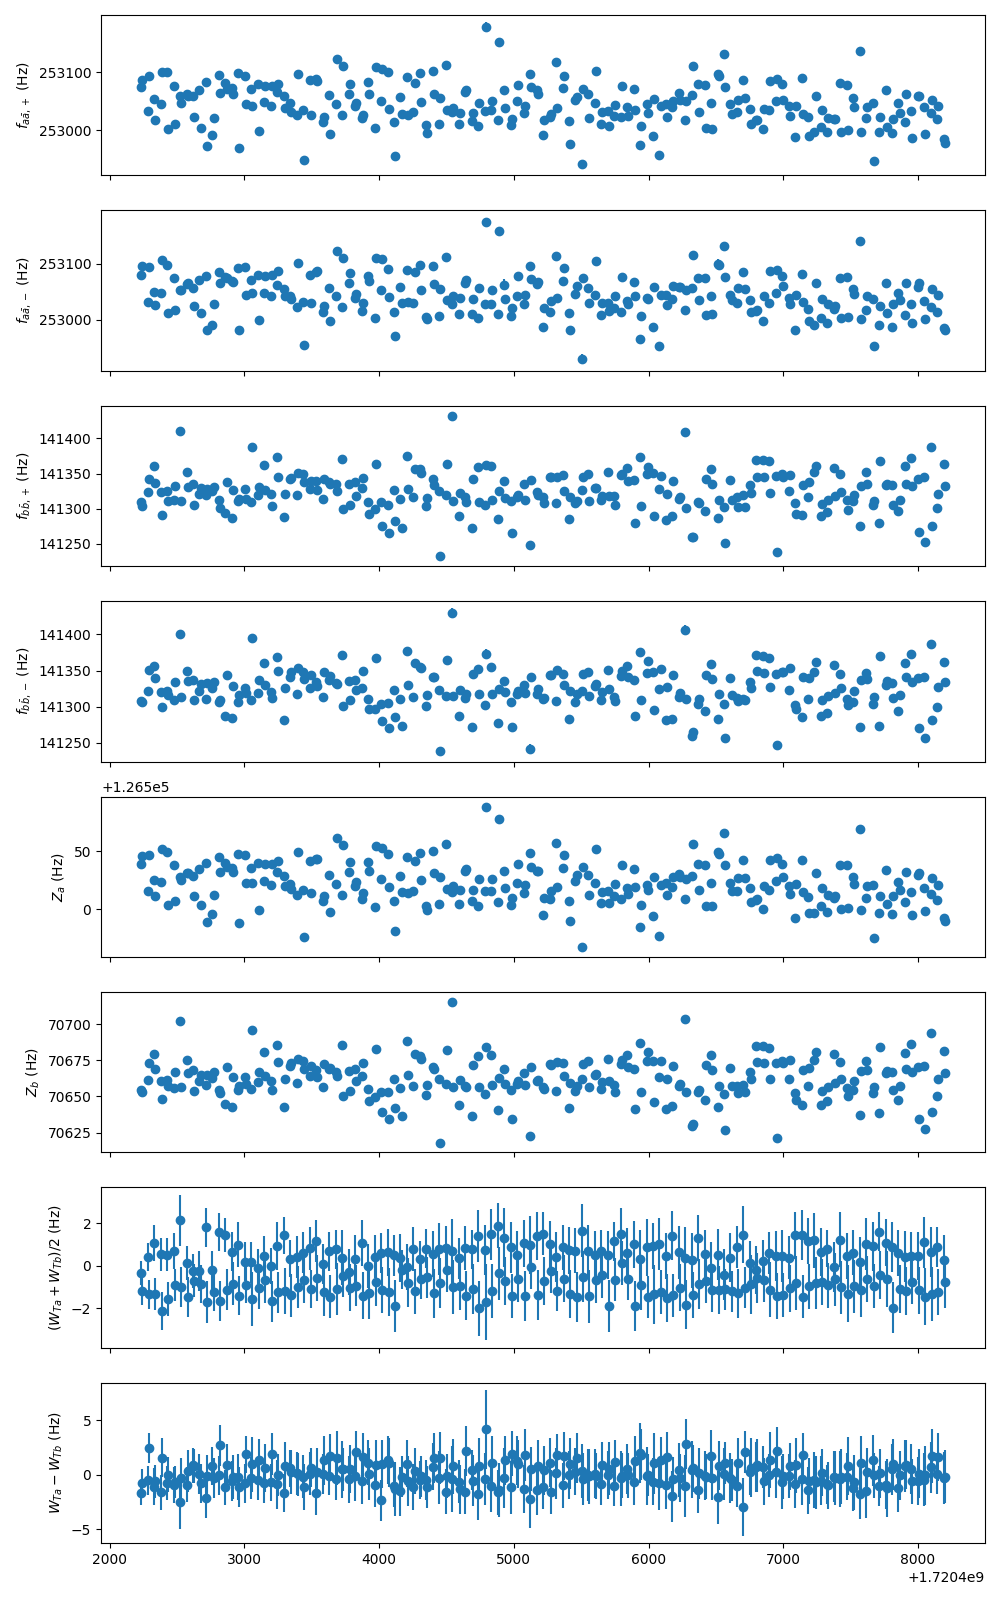

In [295]:
fig, axs = plt.subplots(8, 1, sharex=True, figsize=(10, 16))

errorbar_args = {"fmt": "o", "ls": "none"}

axs[0].set_ylabel("$f_{a\\bar{a}, +}$ (Hz)")
axs[1].set_ylabel("$f_{a\\bar{a}, -}$ (Hz)")
axs[2].set_ylabel("$f_{b\\bar{b}, +}$ (Hz)")
axs[3].set_ylabel("$f_{b\\bar{b}, -}$ (Hz)")
axs[4].set_ylabel("$Z_a$ (Hz)")
axs[5].set_ylabel("$Z_b$ (Hz)")
axs[6].set_ylabel("$(W_{Ta} + W_{Tb}) / 2$ (Hz)")
axs[7].set_ylabel("$W_{Ta} - W_{Tb}$ (Hz)")
for kk, d in enumerate([f_p_a, f_m_a, f_p_b, f_m_b, Z_a, Z_b, (W_T_a + W_T_b) / 2, W_T_a - W_T_b]):
    axs[kk].errorbar(
        start_times_a, unumpy.nominal_values(d), unumpy.std_devs(d),
        **errorbar_args
    )
plt.tight_layout()
plt.show()

-0.09964876490376808 1.484610414483134


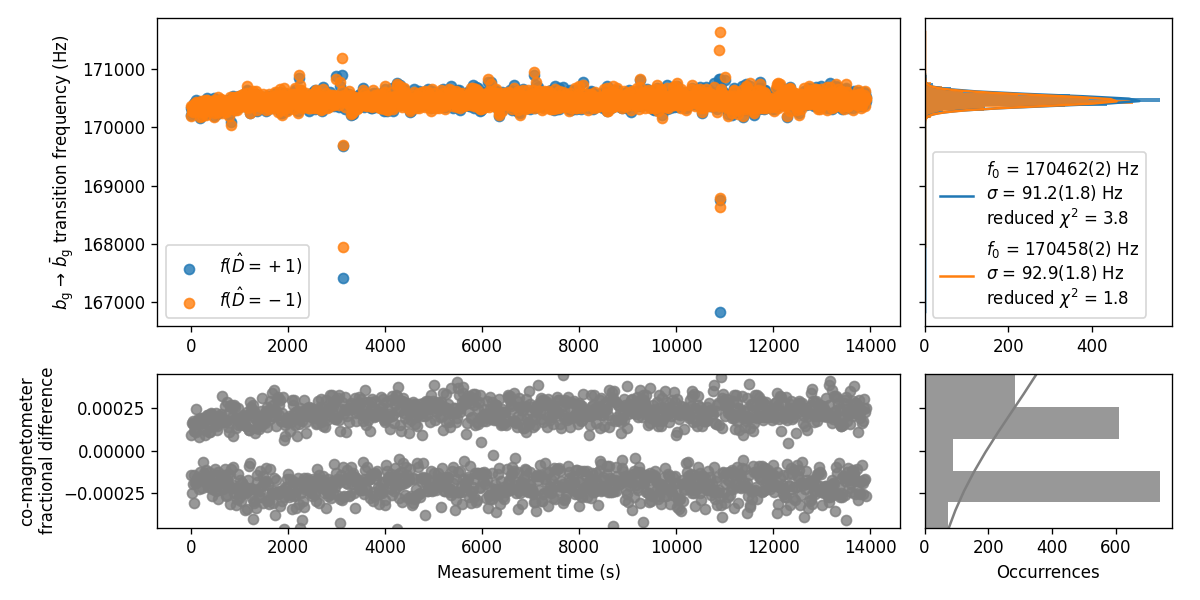

In [75]:
def gaussian(f, f0, sigma, a, c):
    return a * np.exp(-(f-f0)**2 / (2 * sigma**2)) + c

def gaussian_fitter_histogram(xs, hists):
    xs = xs[1:] - (xs[1] - xs[0]) / 2
    nonzero_hist_mask = hists != 0
    fitter = Fitter(gaussian)
    fitter.set_nicknames({"f0": "$f_0$", "sigma": "$\\sigma$", "a": "$a$", "c": "$c$"})
    fitter.set_units({"f0": "Hz", "sigma": "Hz"})
    fitter.set_data(xs[nonzero_hist_mask], hists[nonzero_hist_mask], np.sqrt(hists[nonzero_hist_mask]))
    fitter.set_p0({"f0": np.average(xs, weights=hists), "sigma": np.std(xs), "a": np.max(hists) - np.min(hists), "c": np.min(hists)})
    return fitter
    
fig, axs = plt.subplots(2, 2, figsize = (10, 5), dpi = 120, sharey="row", gridspec_kw={"width_ratios": [3, 1], "height_ratios": [2, 1]})
n_bins = int(np.sqrt(len(all_results)))
bins_alpha = 0.8

for kk, D_mask in enumerate([D_p1_mask, D_m1_mask]):
    mask = unlock_mask & start_mask & b_mask & D_mask
    fs = np.array([result["freq_center"] for result in all_results[mask]])
    ts = np.array([result["start_time"] for result in all_results[mask]])
    ts -= ts[0]

    if kk == 0:
        label = "$f(\\hat{D} = +1)$"
    else:
        label = "$f(\\hat{D} = -1)$"
    axs[0][0].scatter(ts, fs, label=label, alpha=bins_alpha)
    axs[0][1].hist(fs, bins=n_bins, orientation="horizontal", alpha=bins_alpha)
   
    hists, xs = np.histogram(fs, bins=n_bins)
    fitter = gaussian_fitter_histogram(xs, hists)
    fitter.fit()
    label = fitter.result_str("f0") + "\n" + fitter.result_str("sigma") + f"\nreduced $\\chi^2$ = {fitter.reduced_chi:.1f}"
    xs_plt = np.linspace(np.min(fs), np.max(fs), 100)
    axs[0][1].plot(fitter.fitted_value(xs_plt), xs_plt, color=f"C{kk}", label=label)

mask1 = unlock_mask & start_mask & b_mask & D_p1_mask
mask2 = unlock_mask & start_mask & b_mask & D_m1_mask
fs = np.array([result["freq_center"] for result in all_results[mask1]]) - np.array([result["freq_center"] for result in all_results[mask2]])
avg_f = (np.array([result["freq_center"] for result in all_results[mask1]]) + np.array([result["freq_center"] for result in all_results[mask2]])) / 2

label = "$f(\\hat{D} = +1) - f(\\hat{D} = -1)$"
axs[1][0].scatter(ts, fs / avg_f, label=label, alpha=bins_alpha, color="C7")
axs[1][1].hist(fs / avg_f, bins=n_bins, orientation="horizontal", alpha=bins_alpha, color="C7")
print(np.average(fs), np.std(fs) / np.sqrt(len(fs / avg_f)))

hists, xs = np.histogram(fs / avg_f, bins=n_bins)
fitter = gaussian_fitter_histogram(xs, hists)
fitter.fit()
label = fitter.result_str("f0") + "\n" + fitter.result_str("sigma") + f"\nreduced $\\chi^2$ = {fitter.reduced_chi:.1f}"
xs_plt = np.linspace(np.min(fs / avg_f), np.max(fs / avg_f), 100)
axs[1][1].plot(fitter.fitted_value(xs_plt), xs_plt, color=f"C7", label=label)

axs[1][0].set_xlabel("Measurement time (s)")
axs[0][0].set_ylabel("$b_\mathrm{g}\ \\to\ \\bar{b}_\mathrm{g}$ transition frequency (Hz)")
axs[1][0].set_ylabel("co-magnetometer\nfractional difference")
axs[0][0].legend()
axs[1][1].set_xlabel("Occurrences")
axs[0][1].legend()
axs[1][0].set_ylim(-0.00045, 0.00045)
plt.tight_layout()
plt.show()

8(6) Hz


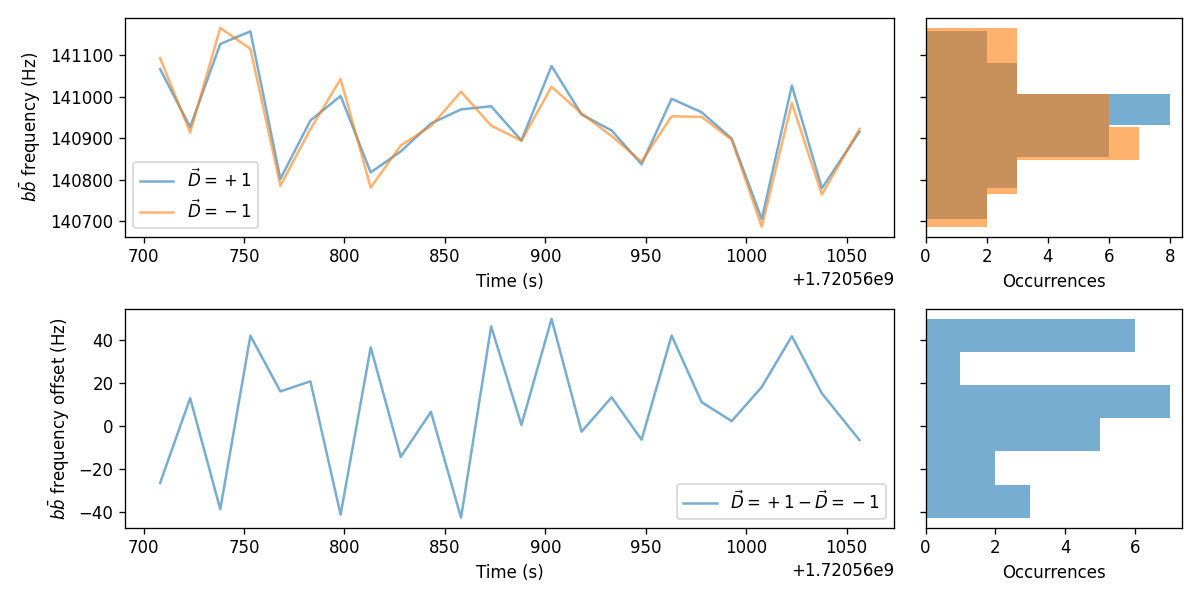

In [961]:
fig, axs = plt.subplots(2, 2, figsize = (10, 5), dpi = 120, sharey="row", gridspec_kw={"width_ratios": [3, 1]})
n_bins = int(np.sqrt(len(all_results)))
bins_alpha = 0.6

for kk, D_mask in enumerate([D_p1_mask, D_m1_mask]):
    mask = unlock_mask & start_mask & b_mask & D_mask
    fs = np.array([result["freq_center"] for result in all_results[mask]])
    ts = np.array([result["epoch_times"][0] for result in all_results[mask]])

    if kk == 0:
        label = "$\\vec{D} = +1$"
    else:
        label = "$\\vec{D} = -1$"
    axs[0][0].plot(ts, fs, label=label, alpha=bins_alpha)
    axs[0][1].hist(fs, bins=n_bins, orientation="horizontal", alpha=bins_alpha)
    
    hists, xs = np.histogram(fs, bins=n_bins)
    # fitter = gaussian_fitter_histogram(xs, hists)
    # fitter.fit()
    # label = fitter.result_str("f0") + "\n" + fitter.result_str("sigma") + f"\nreduced $\\chi^2$ = {fitter.reduced_chi:.1f}"
    # axs[0][1].plot(fitter.fitted_value(xs), xs, color=f"C{kk}", label=label)
    
axs[0][0].set_xlabel("Time (s)")
axs[0][0].set_ylabel("$b\\bar{b}$ frequency (Hz)")
axs[0][0].legend()
axs[0][1].set_xlabel("Occurrences")


mask1 = unlock_mask & start_mask & b_mask & D_p1_mask
mask2 = unlock_mask & start_mask & b_mask & D_m1_mask
fs = np.array([result["freq_center"] for result in all_results[mask1]]) - np.array([result["freq_center"] for result in all_results[mask2]])
ts = np.array([result["epoch_times"][0] for result in all_results[mask1]])

label = "$\\vec{D} = +1 - \\vec{D} = -1$"
axs[1][0].plot(ts, fs, label=label, alpha=bins_alpha)
axs[1][1].hist(fs, bins=n_bins, orientation="horizontal", alpha=bins_alpha)

fs_avg = np.average(fs)
fs_ste = np.std(fs) / np.sqrt(len(fs))
fs_str = present_float(fs_avg, fs_ste)
print(fs_str, "Hz")

hists, xs = np.histogram(fs, bins=n_bins)
# fitter = gaussian_fitter_histogram(xs, hists)
# fitter.fit()
# label = fitter.result_str("f0") + "\n" + fitter.result_str("sigma") + f"\nreduced $\\chi^2$ = {fitter.reduced_chi:.1f}"
# axs[1][1].plot(fitter.fitted_value(xs), xs, color=f"C0", label=label)
    
axs[1][0].set_xlabel("Time (s)")
axs[1][0].set_ylabel("$b\\bar{b}$ frequency offset (Hz)")
axs[1][0].legend()
axs[1][1].set_xlabel("Occurrences")

plt.tight_layout()
plt.show()

-30(30) Hz


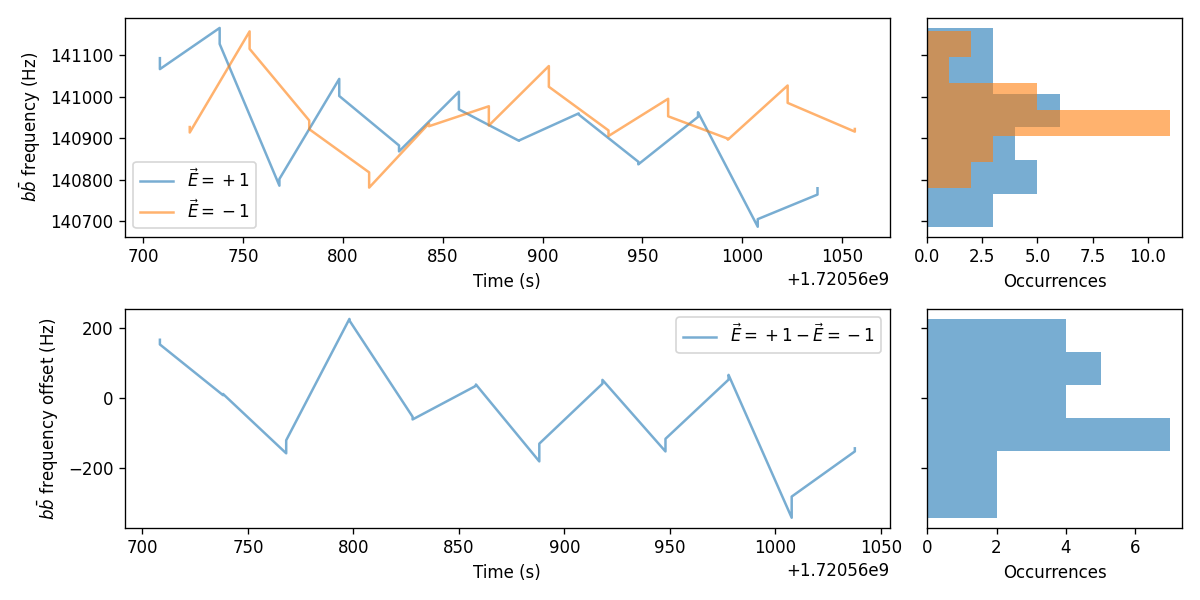

In [962]:
fig, axs = plt.subplots(2, 2, figsize = (10, 5), dpi = 120, sharey="row", gridspec_kw={"width_ratios": [3, 1]})
n_bins = int(np.sqrt(len(all_results)))
bins_alpha = 0.6

for kk, E_mask in enumerate([E_p1_mask, E_m1_mask]):
    mask = unlock_mask & start_mask & b_mask & E_mask
    fs = np.array([result["freq_center"] for result in all_results[mask]])
    ts = np.array([result["epoch_times"][0] for result in all_results[mask]])

    if kk == 0:
        label = "$\\vec{E} = +1$"
    else:
        label = "$\\vec{E} = -1$"
    axs[0][0].plot(ts, fs, label=label, alpha=bins_alpha)
    axs[0][1].hist(fs, bins=n_bins, orientation="horizontal", alpha=bins_alpha)
    
    hists, xs = np.histogram(fs, bins=n_bins)
    # fitter = gaussian_fitter_histogram(xs, hists)
    # fitter.fit()
    # label = fitter.result_str("f0") + "\n" + fitter.result_str("sigma") + f"\nreduced $\\chi^2$ = {fitter.reduced_chi:.1f}"
    # axs[0][1].plot(fitter.fitted_value(xs), xs, color=f"C{kk}", label=label)
    
axs[0][0].set_xlabel("Time (s)")
axs[0][0].set_ylabel("$b\\bar{b}$ frequency (Hz)")
axs[0][0].legend()
axs[0][1].set_xlabel("Occurrences")


mask1 = unlock_mask & start_mask & b_mask & E_p1_mask
mask2 = unlock_mask & start_mask & b_mask & E_m1_mask
fs = np.array([result["freq_center"] for result in all_results[mask1]]) - np.array([result["freq_center"] for result in all_results[mask2]])
ts = np.array([result["epoch_times"][0] for result in all_results[mask1]])

label = "$\\vec{E} = +1 - \\vec{E} = -1$"
axs[1][0].plot(ts, fs, label=label, alpha=bins_alpha)
axs[1][1].hist(fs, bins=n_bins, orientation="horizontal", alpha=bins_alpha)

fs_avg = np.average(fs)
fs_ste = np.std(fs) / np.sqrt(len(fs))
fs_str = present_float(fs_avg, fs_ste)
print(fs_str, "Hz")

hists, xs = np.histogram(fs, bins=n_bins)
# fitter = gaussian_fitter_histogram(xs, hists)
# fitter.fit()
# label = fitter.result_str("f0") + "\n" + fitter.result_str("sigma") + f"\nreduced $\\chi^2$ = {fitter.reduced_chi:.1f}"
# axs[1][1].plot(fitter.fitted_value(xs), xs, color=f"C0", label=label)
    
axs[1][0].set_xlabel("Time (s)")
axs[1][0].set_ylabel("$b\\bar{b}$ frequency offset (Hz)")
axs[1][0].legend()
axs[1][1].set_xlabel("Occurrences")

plt.tight_layout()
plt.show()

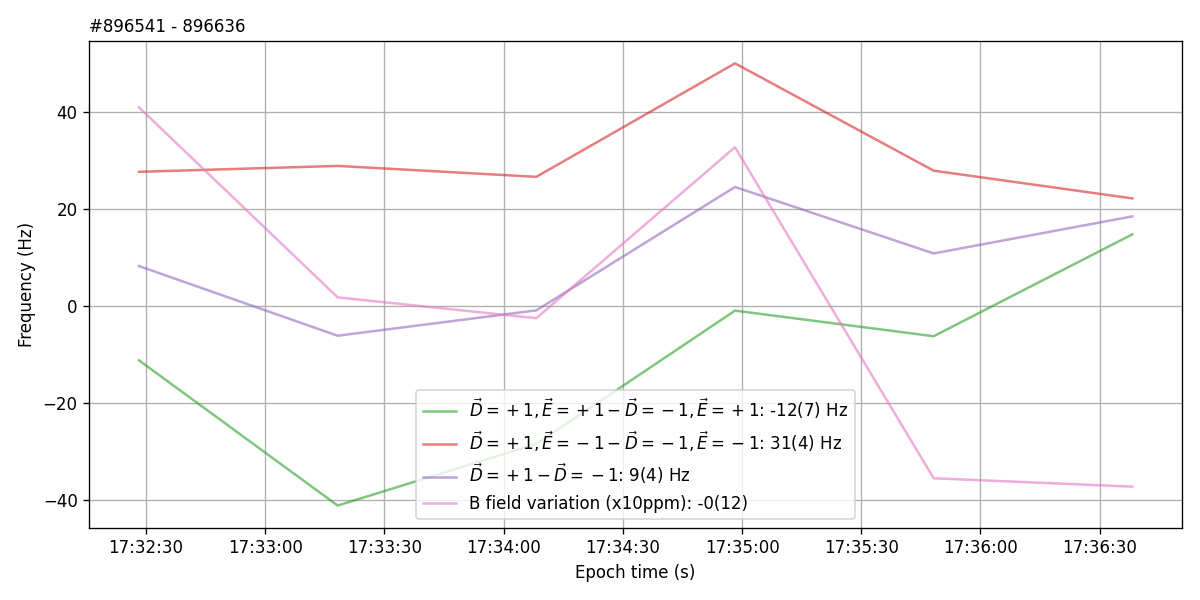

In [963]:
# fig, ax = plt.subplots(figsize = (10, 5), dpi = 120)
n_bins = int(np.sqrt(len(all_results))) * 2
bins_alpha = 0.6

data = []
for ll, D_mask in enumerate([D_p1_mask, D_m1_mask]):
    for kk, E_mask in enumerate([E_p1_mask, E_m1_mask]):
        mask = unlock_mask & start_mask & b_mask & D_mask & E_mask
        data.append([result["epoch_times"][0] for result in all_results[mask]])
        data.append([result["freq_center"] for result in all_results[mask]])
sample_times, D_p1_E_p1, D_p1_E_m1, D_m1_E_p1, D_m1_E_m1 = uniform_averaging(average_time, *tuple(data))

# for kk, data in enumerate([D_p1_E_p1, D_p1_E_m1, D_m1_E_p1, D_m1_E_m1]):
#     if kk < 2:
#         label = "$\\vec{D} = +1, "
#     else:
#         label = "$\\vec{D} = -1, "
#     if kk % 2 == 0:
#         label += "\\vec{E} = +1$"
#     else:
#         label += "\\vec{E} = -1$"
#     ts = sample_times
#     fs = data
    
#     ts_plt = [datetime.fromtimestamp(t) for t in ts]
#     ax.plot(ts_plt, fs, alpha=bins_alpha, label=label, color=f"C{kk}",)
    
# ax.set_xlabel("Toronto time")
# ax.set_ylabel("Time-binned $b\\bar{b}$ frequency (Hz)")
# ax.legend()
# plt.tight_layout()
# plt.show()

fig, ax = plt.subplots(figsize = (10, 5), dpi = 120)
n_bins = int(np.sqrt(len(all_results))) * 2
bins_alpha = 0.6

D_p1_E_p1_D_p1_E_m1 = D_p1_E_p1 - D_p1_E_m1
D_m1_E_p1_D_m1_E_m1 = D_m1_E_p1 - D_m1_E_m1

D_p1_E_p1_D_m1_E_p1 = D_p1_E_p1 - D_m1_E_p1
D_p1_E_m1_D_m1_E_m1 = D_p1_E_m1 - D_m1_E_m1

D_p1_D_m1 = ((D_p1_E_p1 + D_p1_E_m1) - (D_m1_E_p1 + D_m1_E_m1)) / 2
E_p1_E_m1 = ((D_p1_E_p1 + D_m1_E_p1) - (D_p1_E_m1 + D_m1_E_m1)) / 2

all = (D_p1_E_p1 + D_p1_E_m1 + D_m1_E_p1 + D_m1_E_m1) / 4
all = ((all / np.average(all)) - 1) * 1e5

for kk, data in enumerate([D_p1_E_p1_D_p1_E_m1, D_m1_E_p1_D_m1_E_m1, D_p1_E_p1_D_m1_E_p1, D_p1_E_m1_D_m1_E_m1, D_p1_D_m1, E_p1_E_m1, all]):
    if kk == 0:
        label = "$\\vec{D} = +1, \\vec{E} = +1 - \\vec{D} = +1, \\vec{E} = -1$"
        continue
    if kk == 1:
        label = "$\\vec{D} = -1, \\vec{E} = +1 - \\vec{D} = -1, \\vec{E} = -1$"
        continue
    if kk == 2:
        label = "$\\vec{D} = +1, \\vec{E} = +1 - \\vec{D} = -1, \\vec{E} = +1$"
    if kk == 3:
        label = "$\\vec{D} = +1, \\vec{E} = -1 - \\vec{D} = -1, \\vec{E} = -1$"
    if kk == 4:
        label = "$\\vec{D} = +1 - \\vec{D} = -1$"
    if kk == 5:
        label = "$\\vec{E} = +1 - \\vec{E} = -1$"
        continue
    if kk == 6:
        label = "B field variation (x10ppm)"
    ts = sample_times
    fs = data
    
    ts_plt = [datetime.fromtimestamp(t) for t in ts]
    fs_avg = np.average(fs)
    fs_ste = np.std(fs) / np.sqrt(len(fs))
    fs_str = present_float(fs_avg, fs_ste)
    if kk != 6:
        fs_str += " Hz"
    ax.plot(ts_plt, fs, alpha=bins_alpha, label=label + f": {fs_str}", color=f"C{kk}")

ax.text(0, 1.02, f"#{first} - {last}", transform=ax.transAxes)
ax.set_xlabel("Epoch time (s)")
ax.set_ylabel("Frequency (Hz)")
ax.grid()
ax.legend()
plt.tight_layout()
plt.show()

## Fluctuations in LF Ramsey (1 data point)

KeyError: 'use_opposite_field'

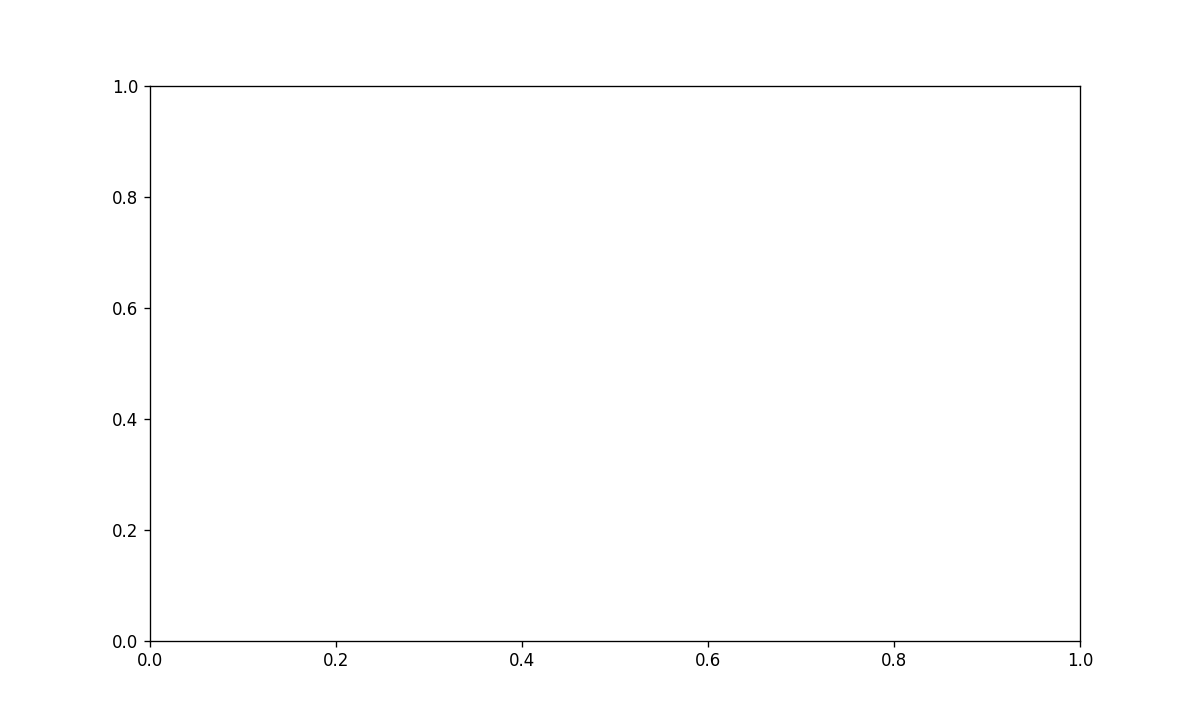

In [709]:
data = {
    # "original": (588222, 588418),
    # "sync 0.713(0.01)s": (592518, 592702),
    # "no sync": (592704, 592916),
    # "sync 0.713(0.001)s": (592923, 593092),
    # "no sync 2": (593094, 593306),
    # "no sync 3": (593328, 593553),


    # COMPARISON:    
    # "350 ao 32 detects": (594308, 594529),
    # "350 ao 64 detects": (594531, 594752),
    # "350 ao 256 detects": (594754, 594972),
    # "400 ao 64 detects": (594974, 595192),
    # "425 ao 64 detects": (595417, 595638),
    # "450 ao 64 detects": (595194, 595415),
    # "400 ao 64 detects rep": (595640, 595863),
    # "350 ao 64 detects rep": (595865, 596088),


    "350 ao 64 detects long data": (596089, 599091),
    # "350 ao 64 detects long data (SAME BUT IGNORE FIRST 1000)": (597089, 599091),
}
fig, ax = plt.subplots(figsize = (10, 6), dpi = 120)
for ll, (label, data_range) in enumerate(data.items()):
    data_list = data_identification_to_list(data_range)
    ratios, headers, E_field = get_voltage_ratios(data_list)
    # xs = [header["data_info"]["save_epoch_time"]-headers[0]["data_info"]["save_epoch_time"] for header in headers]
    xs = [i for i in range(len(headers))]
    ys = (1-ratios)
    if E_field[0] is not None:
        ax.scatter(xs, ys[:,0], label=label + " pos Stark", s = 30)
        ax.scatter(xs, ys[:,1], label=label + " neg Stark", s = 30)
        # ax.scatter(xs, ys[:,0]-ys[:,1], label=label + "$\\vec{D}=+1$ - $\\vec{D}=-1$", s = 30)

ax.set_xlabel(f"Save time (s)")
ax.set_ylabel("Normalized absorption")
ax.legend()
ax.grid()
plt.tight_layout()
plt.show()

fig = plt.figure(figsize = (10, 8), dpi = 120)
gs = fig.add_gridspec(2, 2,  width_ratios=(4, 1), height_ratios=(1, 4),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.0, hspace=0.0)
ax = fig.add_subplot(gs[1, 0])
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)
ax_histx.tick_params(axis="x", labelbottom=False)
ax_histy.tick_params(axis="y", labelleft=False)
for ll, (label, data_range) in enumerate(data.items()):
    data_list = data_identification_to_list(data_range)
    ratios, headers, E_field = get_voltage_ratios(data_list)
    xsys = (1-ratios)
    xs = xsys[:, 0]
    ys = xsys[:, 1]
    bins = 50
    ax.scatter(xs, ys, s = 30, alpha=0.7, label = f"{label}: $R$ = {pearsonr(xs, ys).statistic:.4f}")
    ax_histx.hist(xs, bins=bins, alpha=0.7, label=f"$\\mu/\\sigma$ = {np.average(xs)/np.std(xs):.4f}")
    ax_histy.hist(ys, bins=bins, alpha=0.7, orientation='horizontal', label=f"$\\mu/\\sigma$ = {np.average(ys)/np.std(ys):.4f}")

ax.set_xlabel("Normalized absorption $\\vec{D}=+1$")
ax.set_ylabel("Normalized absorption $\\vec{D}=-1$")
ax_histx.set_ylabel("Count")
ax_histy.set_xlabel("Count")
ax.grid()
ax.legend()
ax_histx.legend()
ax_histy.legend()
plt.show()



## Fluctuations in Hole burning

0.004199764272051945
0.006971096344848625
0.003937793905072617
0.0034490014055966814


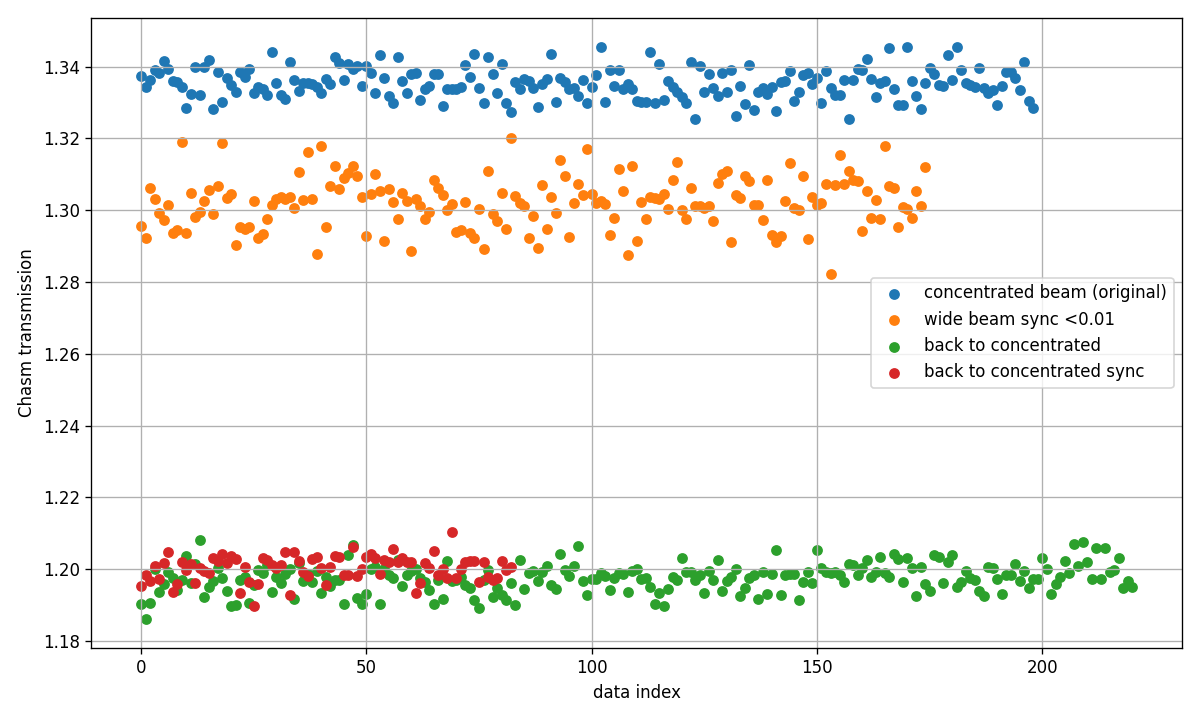

In [159]:
data = {
    # "chasm -> immediate detect": (588421, 588753)

    # chasm -> immediate detect -> wait -> detect
    "concentrated beam (original)": (589333, 589531),
    # "3 decimal sync": (590121, 590239),
    # "wider beam diameter": (590407, 591294),
    # "back to concentrated beam 2": (591568, 591693),
    # "wide beam 2": (591916, 592043),
    # "wide beam sync <0.1": (592090, 592150),
    "wide beam sync <0.01": (592271, 592445),
    "back to concentrated": (593659, 593879),
    "back to concentrated sync": (593891, 593973),
}
fig, ax = plt.subplots(figsize = (10, 6), dpi = 120)
for ll, (label, data_range) in enumerate(data.items()):
    data_list = data_identification_to_list(data_range)
    ys = []
    xs = []
    for kk, data_num in enumerate(data_list):
        transmissions_avg, monitors_avg, headers = averaged_data_from_number(data_num)
        # xs.append(headers["data_info"]["save_epoch_time"])
        xs.append(kk)
        ys.append((transmissions_avg["antihole"][0]/monitors_avg["antihole"][0]))
    print(np.std(ys))
    ax.scatter(xs, ys, s = 30, label=label)

ax.set_xlabel(f"data index")
ax.set_ylabel("Chasm transmission")
ax.legend()
ax.grid()
plt.tight_layout()
plt.show()

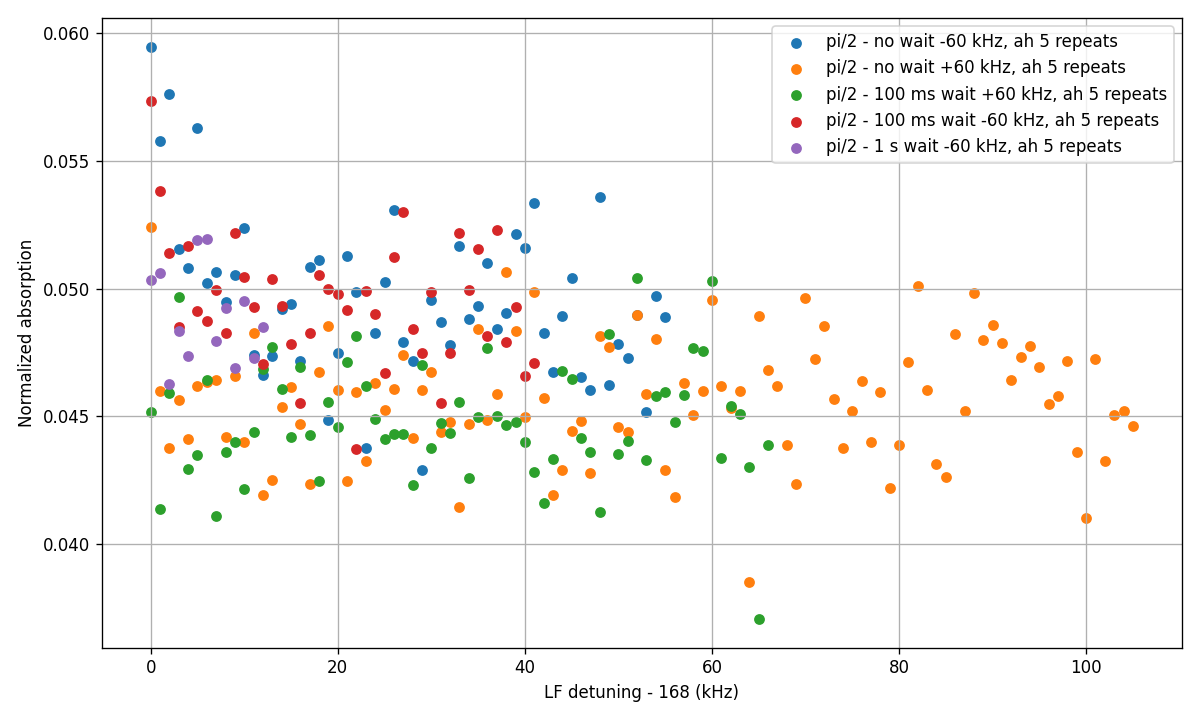

In [274]:
data = {
    # "pi/2 - no wait -60 kHz": (609490, 609544),
    # "pi/2 - no wait +60 kHz": (609545, 609591),
    # "pi/2 - no wait no rf": (609603, 609647),
    # "rf_b +60 kHz": (609649, 609707),
    # "rf_b -60 kHz": (609709, 609741),
    # "pi/2 - no wait +60 kHz, ah 20 repeats": (609743, 609826),
    # "pi/2 - no wait -60 kHz, ah 20 repeats": (609828, 609930),
    "pi/2 - no wait -60 kHz, ah 5 repeats": (609932, 609987),
    "pi/2 - no wait +60 kHz, ah 5 repeats": (609989, 610094),
    "pi/2 - 100 ms wait +60 kHz, ah 5 repeats": (610097, 610163),
    "pi/2 - 100 ms wait -60 kHz, ah 5 repeats": (610176, 610217),
    "pi/2 - 1 s wait -60 kHz, ah 5 repeats": (610249, 610261),
}

fig, ax = plt.subplots(figsize = (10, 6), dpi = 120)
for ll, (label, data_range) in enumerate(data.items()):
    data_list = data_identification_to_list(data_range)
    ratios, headers, E_field = get_voltage_ratios(data_list)
    xs = [header["data_info"]["data_number"] for header in headers]
    xs = np.array(xs) - xs[0]
    ys = (1-ratios)[:, 0]
    ax.scatter(xs, ys, label=label, s = 30)

ax.set_xlabel(f"LF detuning - {headers[0]["params"]["lf"]["center_frequency"].to("kHz").magnitude} (kHz)")
ax.set_ylabel("Normalized absorption")
ax.legend()
ax.grid()
plt.tight_layout()
plt.show()